In [1]:
#Importamos las librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy
import matplotlib.animation as animation
import matplotlib
import tkinter as tk

### A modo de simplicidad, consideraremos G como el grafo de 7 nodos completo, con pesos unitarios. La configuración óptima asociada al CPP debiera ser cualquier ciclo euleriano de peso 21.

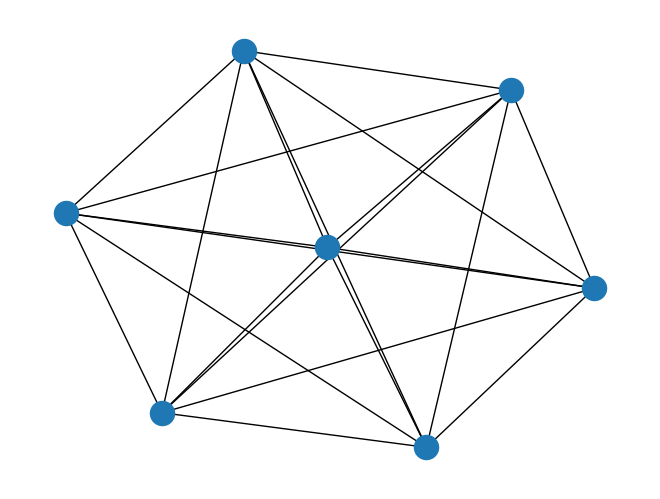

In [2]:
G = nx.graph_atlas(1252) #Estudiaremos el grafo de 7 nodos completo.
nx.draw(G,)

In [3]:
for u, v in G.edges:
    G[u][v]['weight'] = 1

# Printeamos los datos de cada arista, notando que están nombradas en orden ascendente.
for u, v, data in G.edges(data=True):
    print(f"Arista {u}-{v} tiene peso {data['weight']}")

Arista 0-1 tiene peso 1
Arista 0-2 tiene peso 1
Arista 0-3 tiene peso 1
Arista 0-4 tiene peso 1
Arista 0-5 tiene peso 1
Arista 0-6 tiene peso 1
Arista 1-2 tiene peso 1
Arista 1-3 tiene peso 1
Arista 1-4 tiene peso 1
Arista 1-5 tiene peso 1
Arista 1-6 tiene peso 1
Arista 2-3 tiene peso 1
Arista 2-4 tiene peso 1
Arista 2-5 tiene peso 1
Arista 2-6 tiene peso 1
Arista 3-4 tiene peso 1
Arista 3-5 tiene peso 1
Arista 3-6 tiene peso 1
Arista 4-5 tiene peso 1
Arista 4-6 tiene peso 1
Arista 5-6 tiene peso 1


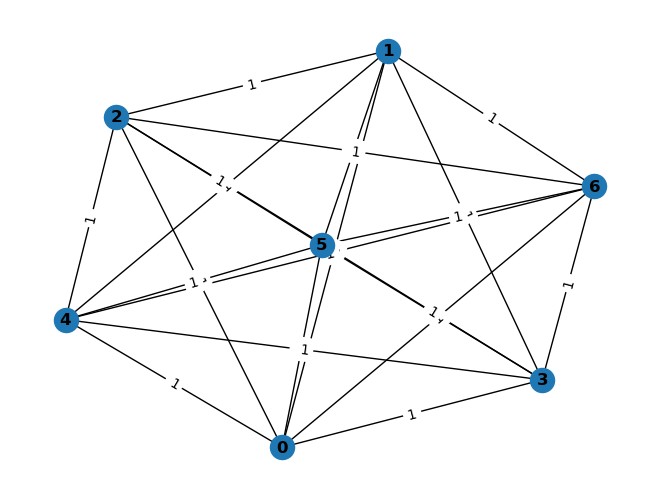

In [4]:
# Dibujamos el grafo con las etiquetas
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Etiquetamos las aristas
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

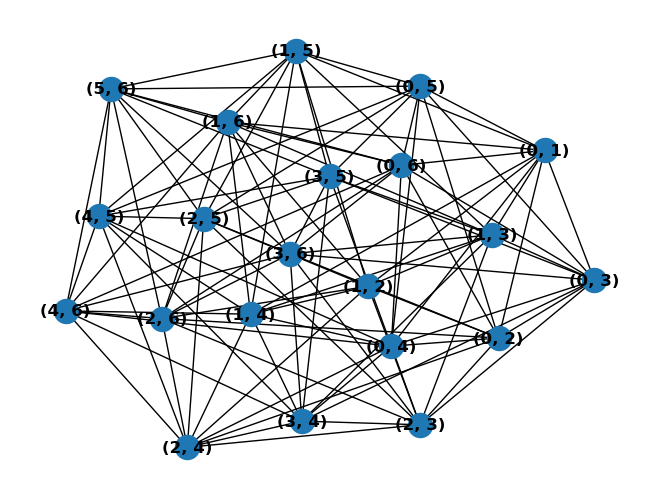

In [5]:
# Generamos el grafo de líneas, que nos servirá para construir la configuración inicial.
L = nx.line_graph(G)

for u, v in L.edges:
    L[u][v]['weight'] = 1

for u, v in L.edges:
    L[u][v]['shortest_path'] = None
    
# Lo dibujamos
pos = nx.spring_layout(L)  # You can choose a different layout if needed
nx.draw(L, pos, with_labels=True, font_weight='bold')

plt.show()

Nuestra idea para tener la configuración inicial para el SA, es obtenerla de manera artificial teniendo la lista de nodos del grafo de líneas, tomando samples de su mismo tamaño hasta obtener que la primera arista contenga al 0.
La idea acá es ejecutar la siguiente celda hasta obtener esto mismo.

En paralelo, definimos también la relación de vecindad para las secuencias de aristas permutando las aristas, teniendo cuidado al permutar la primera, pues solamente podemos cambiarla por otra arista que también incida con el 0 (primer nodo).

In [6]:
l = list(L.nodes()) #Será una lista de tuplas de aristas.
path_ejemplo = random.sample(l,len(l))
#Le agregamos el 0 al final de la lista, simbolizando que tenemos que volver al nodo inicial tras cumplir con todas las aristas.
path_ejemplo.append(0)

print("El camino inicial es:", path_ejemplo) #Acá tendremos un reordenamiento de los nodos de L, si este reordenamiento es tal que su primera tupla
                    #tiene al 0, avanzamos.

def vecino(path):  #Dado un tour que pase por todos los vertices en L(G) se obtiene un vecino de este:
    N=len(path)-1 #Ignoramos el 0 agregado al final
    a = np.random.randint(0,N) #Elegimos un elemento al azar entre la secuencia
    while True:
        b = np.random.randint(1,N) #Tomamos otro y cubrimos el caso en el cual a == 0
        if b != a:
            if a==0:
                if path[b][0]==0 or path[b][1]==0:
                    break
            else:
                break
    q = copy.deepcopy(path)
    c = q[a]
    q[a] = q[b]
    q[b] = c
    return q

print("\nUn ejemplo de vecino del camino inicial:", vecino(path_ejemplo))

print("\nEjecutar hasta que la primera arista de la secuencia contenga al 0.")


El camino inicial es: [(0, 1), (1, 2), (1, 3), (1, 5), (5, 6), (1, 6), (2, 5), (0, 5), (4, 5), (0, 6), (2, 4), (2, 6), (3, 4), (3, 5), (0, 4), (0, 3), (3, 6), (4, 6), (0, 2), (1, 4), (2, 3), 0]

Un ejemplo de vecino del camino inicial: [(0, 1), (1, 2), (1, 3), (1, 5), (5, 6), (1, 6), (2, 5), (0, 5), (4, 5), (0, 6), (2, 4), (2, 6), (3, 4), (0, 3), (0, 4), (3, 5), (3, 6), (4, 6), (0, 2), (1, 4), (2, 3), 0]

Ejecutar hasta que la primera arista de la secuencia contenga al 0.


Como bien se indicó en el repositorio, enumeramos los pasos:

### 3. Algoritmo de Reconstrucción de Caminos

Dada un orden de prioridad $s=(e_1,\dots,e_m)$, queremos obtener $P_s$ camino factible para el CPP asociado a $s$, para esto, aplicamos lo siguiente:
1. Definimos $P_s = [0]$ como la lista de los vértices por los que recorre en ese orden, posee al cero porque es la suposición inicial que definimos ($e_1$ incidente en $0$)
2. Como $e_1=0v$, $P_s \leftarrow P_s + v$
3. $i \leftarrow 1$
4. Definimos variable VérticeActual $\leftarrow v$
5. Definimos AristaActual $\leftarrow e_i=a_1b_1$ y AristaSiguiente $\leftarrow e_{i+1}=a_2b_2$ (en el caso $i=1: a_1=0, b_1=v$) 
6. Si VérticeActual es incidente en $e_2$, digamos $e_2 = vb_2$, actualizamos $P_s \leftarrow P_s + b_2$ y VérticeActual $\leftarrow b_2$ (por simplicidad $e_i = e_1, e_{i+1}=e_2$, para fijar ideas)
7. Si VérticeActual == $b_1$ y $e_2$ es incidente en $a_1$, digamos $e_2=a_1b_2$, actualizamos $P_s \leftarrow P_s + a_1 + b_2$ y VérticeActual $\leftarrow b_2$ (representando que nos devolvemos y duplicamos)
8. Si no, calcular camino de peso mínimo desde VérticeActual a $a_2$ y $b_2$ y tomar el de mínimo peso entre ellos, llamémoslo $P$, y digamos que llega a $a_2$, actualizar $P_s \leftarrow P_s + P + b_2$ y VérticeActual $\leftarrow b_2$, además de esto, todas las aristas que se hayan tomado en $P$ que todavía no se hayan recorrido en el orden de prioridad se eliminan del orden de prioridad, ya que al ya haber pasado por ellas no hay necesidad de pasar nuevamente.
9. Si no se ha llegado al final del orden de prioridad, $i\leftarrow i+1$ y volver a 5.
10. Conectar VérticeActual con 0, con las mismas reglas que lo anterior.

Antes de programar dicha función, necesitamos guardar en una matriz los caminos de peso mínimo entre cada par de nodos.
Para esto, utilizamos como subrutina el algoritmo de Dijkstra (requiere pesos positivos, lo cual es razonable para el problema), y almacenamos en cada entrada de la matriz una tupla $D[i,j] = (camino,peso)$, donde camino es una lista de nodos representando tal camino de peso mínimo y peso es su peso asociado. Las diagonales tendrán (0,0).

In [7]:
def create_matrix(graph):
    num_nodos = len(graph.nodes())
    
    #Definimos los tipos de argumentos para las entradas
    dtype = [('path', object), ('weight', float)]
    
    #Inicializamos la matriz
    matrix = np.zeros((num_nodos, num_nodos), dtype=dtype)

    for i, start_node in enumerate(graph.nodes()):
        for j, end_node in enumerate(graph.nodes()):
            if i == j: #El caso diagonal lo dejamos con ceros.
                continue 
            
            #Encontramos los caminos de peso mínimo para start_node y end_node
            path = nx.shortest_path(graph, source=start_node, target=end_node, weight='weight')
            weight = nx.shortest_path_length(graph, source=start_node, target=end_node, weight='weight')
            matrix[i, j] = (path, weight)

    return matrix

#Ejemplo para ilustrar cómo queda la matriz:
G1 = nx.Graph()
G1.add_edge('A', 'B', weight=2)
G1.add_edge('A', 'C', weight=4)
G1.add_edge('B', 'C', weight=1)
G1.add_edge('B', 'D', weight=7)

result_matrix = create_matrix(G1)
print(result_matrix)



[[(0, 0.) (list(['A', 'B']), 2.) (list(['A', 'B', 'C']), 3.)
  (list(['A', 'B', 'D']), 9.)]
 [(list(['B', 'A']), 2.) (0, 0.) (list(['B', 'C']), 1.)
  (list(['B', 'D']), 7.)]
 [(list(['C', 'B', 'A']), 3.) (list(['C', 'B']), 1.) (0, 0.)
  (list(['C', 'B', 'D']), 8.)]
 [(list(['D', 'B', 'A']), 9.) (list(['D', 'B']), 7.)
  (list(['D', 'B', 'C']), 8.) (0, 0.)]]


Ahora definimos la función Back2GraphPath que nos retorna el camino en el grafo original a partir de L(G).

In [8]:
def Back2GraphPath(path,grafo):   #Toma tour del grafo de lineas y lo pasa a tour en el grafo original

    path_copia = copy.deepcopy(path) #MUY IMPORTANTE: si no copiamos el camino, al momento de remover aristas ya visitadas
                                     #habrá problemas con la CdM después.
    graphPath = [0] #Inicializamos P = [0]

    aristaActual = path_copia[0]    
    i = 0 #Caso i=0, simplemente añadir el nodo v asociado a (0,v).
    graphPath.append(path_copia[0][1])

    matrizCaminos = create_matrix(grafo) #Inicializamos la matriz de caminos cuyas entradas son (camino,peso).
                                         #recordar que "camino" está en formato lista de nodos.
    
    while path_copia[i+1] != 0: #Mientras no estemos en la arista penúltima

        nodoactual = graphPath[-1]
        nodoAnterior = graphPath[-2]
        siguienteArista = path_copia[i+1]


        aristaSet = set(siguienteArista) #Nos servirá ver como conjunto las aristas para el trato de los pasos 6. y 7.
        
        #Primero, tenemos el caso 5.
        if nodoactual in aristaSet:      #nodoactual está en la siguiente arista
            nodoactual = next(iter(aristaSet.difference({nodoactual}))) #Actualizamos el nodo actual por el siguiente
            graphPath.append(nodoactual) #Agregamos tal nodo al camino recuperado del grafo original.

        elif nodoactual not in aristaSet: #Si estamos o bien en el caso 7. o el caso 8.
            if nodoAnterior in aristaSet:   #Caso 7., donde lo que sucede es del estilo: (0,v)(0,w) -> 0,v,0,w
                graphPath.append(nodoAnterior) #Nos devolvemos
                graphPath.append(next(iter(aristaSet.difference({nodoAnterior})))) #Y ahora sí pasamos por el siguiente.
            else:  #Caso 8., camino mínimo.
                nodo1, nodo2 = siguienteArista[0], siguienteArista[1]
                if matrizCaminos[nodoactual,nodo1][1] <= matrizCaminos[nodoactual,nodo2][1]: #Obtenemos el camino de peso mínimo entre ambos.
                    vertices = matrizCaminos[nodoactual,nodo1][0]
                    graphPath = graphPath + vertices[1:] #Agregamos tal camino de peso mínimo
                    graphPath.append(nodo2) #Y completamos con el faltante de la arista que queríamos.
                else:
                    vertices = matrizCaminos[nodoactual,nodo2][0] #Este es el caso análogo.
                    graphPath = graphPath + vertices[1:]
                    graphPath.append(nodo1)
                for j in range(len(vertices)-1): #Borramos todas las aristas siguientes que ya hayamos utilizado en este camino de peso mínimo.
                    edge = (min(vertices[j],vertices[j+1]),max(vertices[j],vertices[j+1]))
                    if edge in path_copia[i+1:]:
                        path_copia.remove(edge) #IMPORTANTE: por esto es relevante copiar path.
                        
        #Avanzamos el índice y redefinimos la arista actual.
        i += 1
        aristaActual = siguienteArista
    
    #Una vez salimos del while (estamos en la penúltima arista), nos dirigimos al 0.
    nodoactual = graphPath[-1]
    if nodoactual == 0: #Si ya habíamos llegado al 0, no hay nada por hacer.
        pass
    elif grafo.has_edge(nodoactual,0): #Si el 0 es vecino del nodo actual, lo agregamos directamente.
        graphPath.append(0)
    else: #Si no, tomamos el camino de peso mínimo.
        vertices = matrizCaminos[nodoactual,0][0]
        graphPath = graphPath + vertices[1:]

    return graphPath

Ahora, definimos la función de costos y definimos la CdM.

In [9]:
# función que calcula el costo de un estado
def fn_costos(D,p,G): #recibe matriz D de costos (proveniente de create_matrix), secuencia de aristas p y grafo G.
    caminoG = Back2GraphPath(p,G)
    N=len(caminoG)
    return sum([D[caminoG[i], caminoG[i+1]][1] for i in range(N-1)])

# funcion que simula una cadena con I pasos, dada una funcion func_beta, estado inicial path_incial,
# grafo G, y matriz de distancias entre nodos de G: D.
# entrega arrays con la secuencia de aristas y costo en cada paso
def CM(I, func_beta, path_inicial, G, D):
    path = path_inicial
    paths  = [path]
    costos = np.asarray(fn_costos(D,path,G))
    u = np.random.uniform(size=I)
    for n in range(I):
        beta = func_beta(n)
        new_path = vecino(path)
        new_cost = fn_costos(D,new_path,G)
        cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))
        if u[n] <= cte:
            path = new_path
        
        paths.append(path)
        costos = np.append(costos, fn_costos(D,path,G))

    return paths, costos

Definimos las funciones beta asociadas a la temperatura.

In [10]:
#funciones beta por comparar
def beta_lin(n,c):
    return n/c
def beta_log(n,c):
    return (1/c)*np.log(1+n)
def beta_cuad(n):
    return n**(2)
def beta_exp(n):
    return 3**n

# beta lineal con c=1
def f1(n, c=1):
    return beta_lin(n,c)
# beta lineal con c fijo como una cota para la oscilación (en este caso, tomamos c=100)
def f2(n, c=100):
    return beta_lin(n,c)
# beta logaritmico con c fijo como la cota para la oscilación.
def f3(n, c=100):
    return beta_log(n,c)

[(0, 1), (0, 3), (3, 5), (2, 6), (0, 2), (3, 4), (1, 3), (1, 5), (1, 2), (0, 6), (2, 3), (2, 5), (1, 4), (4, 6), (3, 6), (0, 4), (0, 5), (5, 6), (4, 5), (2, 4), (1, 6), 0] 22


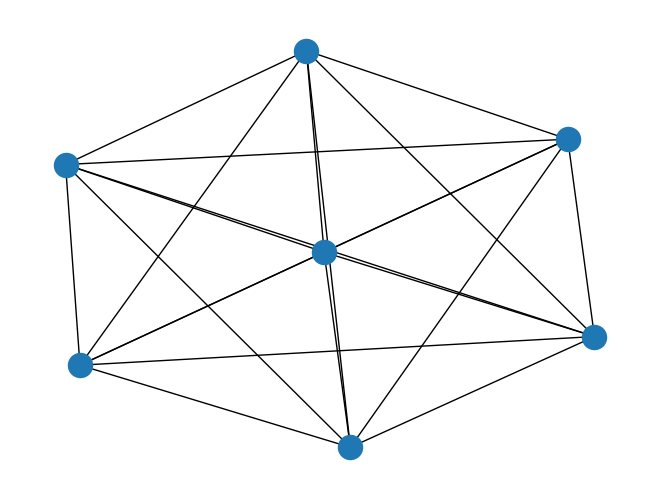

In [11]:
# parametros fijos del modelo
D = create_matrix(G)
path_inicial = path_ejemplo
print(path_inicial, len(path_inicial)) #Obtenemos los datos con los cuales inicializamos la cadena, y volvemos a ver el grafo.
nx.draw(G,)

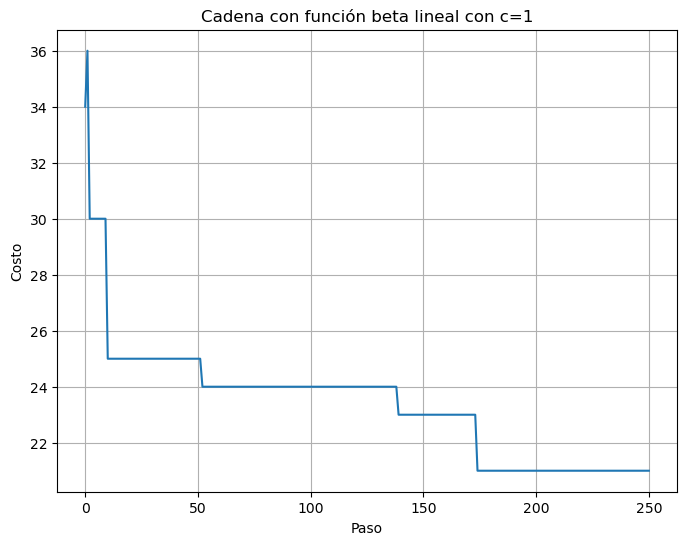

La secuencia de aristas asociada al camino óptimo es: [(0, 1), (5, 6), (0, 3), (3, 5), (2, 6), (0, 6), (1, 3), (4, 5), (1, 6), (0, 2), (1, 4), (0, 5), (4, 6), (3, 6), (3, 4), (2, 4), (2, 3), (1, 2), (0, 4), (2, 5), (1, 5), 0]
El óptimo obtenido es de 21.0


In [12]:
#funcion beta lineal con constante 1
I=250
paths, costos = CM(I, f1, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta lineal con c=1')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt=min(costos)
opt_path = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path)
print('El óptimo obtenido es de {}'.format(round(opt,2)))

Observamos que el óptimo obtenido es 21, tal y como mencionábamos que queríamos de un principio. El algoritmo entonces parece funcionar con este ejemplo de juguete, comprobemos si el camino obtenido es válido y veámoslo en una animación.

In [13]:
camino = Back2GraphPath(opt_path,G)
print(camino) #Printeamos el camino reconstruido en G.

[0, 1, 5, 6, 0, 3, 5, 2, 6, 1, 3, 4, 5, 0, 2, 1, 4, 6, 3, 2, 4, 0]


$\textbf{Nota}$: Al momento de implementar el código de la animación, notamos que en una primera ejecución no corre bien la celda (aparece el pop-up de la ventana conteniendo el .gif, pero no lo carga y hay que cerrarlo a la fuerza matando el kernel), por lo que, luego de ejecutar la celda subsiguiente, se recomienda ejecutar la celda inferior que inicializa el camino óptimo obtenido.

In [14]:
camino = [0, 1, 2, 3, 5, 2, 6, 4, 5, 6, 3, 4, 1, 5, 0, 2, 4, 0, 3, 1, 6, 0]

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy
import matplotlib.animation as animation
import matplotlib
import tkinter as tk

matplotlib.use('TkAgg')

#Definimos H como el grafo completo de 7 nodos
H = nx.complete_graph(7)
pos = nx.spring_layout(H, iterations=200)

#Tomamos path como el camino óptimo
path = camino

def draw_next_status(n):
    plt.cla()
    
    #Creamos un nuevo grafo por cada frame
    G = nx.Graph()
    
    #Le añadimos los nodos
    G.add_nodes_from(H.nodes())
    
    #Contamos cuántas veces llegamos a cada nodo (con la cola de la arista)
    node_count = {node: 0 for node in H.nodes()}
    
    #Agregamos aristas de manera progresiva
    for i in range(n + 1):
        edge_start, edge_end = path[i], path[i + 1] if i + 1 < len(path) else path[0]
        
        #Actualizamos el contador de hit de nodos solo con edge_start
        node_count[edge_start] += 1
        
        #Dibujamos aristas en rojo
        G.add_edge(edge_start, edge_end, color='red')
    
    #Coloreamos los nodos dependiendo de cuántas veces han sido alcanzados.
    edge_colors = ['red' for _ in G.edges()]
    node_colors = [f'C{node_count[node]}' for node in G.nodes()]
    
    nx.draw(G, pos, node_color=node_colors, node_size=700, with_labels=True, edge_color=edge_colors, width=2)

ani = animation.FuncAnimation(plt.gcf(), draw_next_status, interval=1000, frames=len(path) - 1, repeat=False)

writer = animation.PillowWriter(fps=1,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('scatter.gif', writer=writer) #Esta línea guarda la animación como gif, comentarla si no se desea guardar

plt.show()


Ahora, aplicaremos el algoritmo para algunos grafos más complejos y analizaremos su convergencia.
Partimos con un grafo conexo de 20 nodos.

In [11]:
import networkx as nx
import random

#Primero, fijamos los nodos en 20
num_nodes = 20

# Nos ayudamos de la función connected_watts_strogatz_graph para construir un grafo conexo simple
p = 0.2  # Rewiring probability
k = 4    # Number of nearest neighbors

G = nx.connected_watts_strogatz_graph(num_nodes, k, p, seed=42)


(0, 1, {'weight': 2.230803005304586})
(0, 2, {'weight': 1.8445528822239268})
(0, 18, {'weight': 7.395671413585314})
(1, 3, {'weight': 5.612466356093021})
(1, 19, {'weight': 9.762309660870665})
(1, 8, {'weight': 4.762457080194519})
(2, 3, {'weight': 1.0965721748274633})
(2, 4, {'weight': 5.664453337997762})
(2, 5, {'weight': 9.629086961938244})
(3, 5, {'weight': 1.1637710265165055})
(3, 17, {'weight': 9.915862864946538})
(4, 6, {'weight': 2.5942837011492688})
(4, 13, {'weight': 8.014654212140368})
(5, 7, {'weight': 4.5858973214590275})
(6, 7, {'weight': 1.3127113014681524})
(6, 8, {'weight': 9.8047434503108})
(7, 8, {'weight': 5.293359922882})
(7, 9, {'weight': 3.463078781838921})
(7, 12, {'weight': 9.325480717779906})
(8, 10, {'weight': 6.4334419916179675})
(8, 17, {'weight': 2.9521377009004635})
(9, 10, {'weight': 4.297612131759854})
(9, 11, {'weight': 5.619790141361082})
(10, 11, {'weight': 7.588740926342651})
(10, 12, {'weight': 4.68025054303917})
(10, 14, {'weight': 1.2514752096338

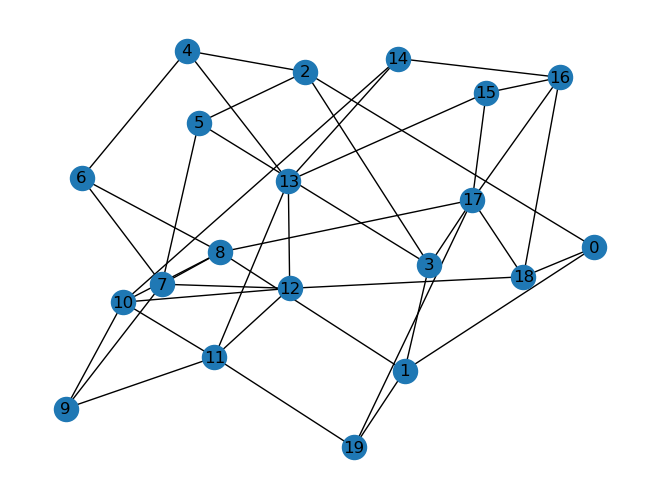

In [12]:
# Asignamos pesos aleatorios entre 1 y 10.
for edge in G.edges():
    weight = random.uniform(1, 10)
    G[edge[0]][edge[1]]['weight'] = weight

# Los visualizamos
for edge in G.edges(data=True):
    print(edge)

# Dibujamos el grafo
nx.draw(G, with_labels=True)

Los siguientes pasos son análogos al caso de K7: construir la configuración inicial, ver el grafo de líneas, y fijar las funciones beta de la temperatura.

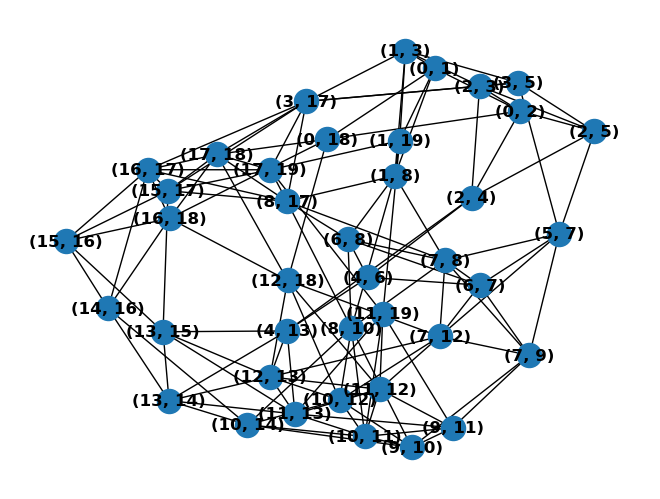

In [13]:
# Generamos el grafo de líneas, que nos servirá para construir la configuración inicial.
L = nx.line_graph(G)

for u, v in L.edges:
    L[u][v]['weight'] = 1

for u, v in L.edges:
    L[u][v]['shortest_path'] = None
    
# Lo dibujamos
pos = nx.spring_layout(L)
nx.draw(L, pos, with_labels=True, font_weight='bold')

plt.show()

In [19]:
l = list(L.nodes()) #Será una lista de tuplas de aristas.
path_ejemplo = random.sample(l,len(l))
#Le agregamos el 0 al final de la lista, simbolizando que tenemos que volver al nodo inicial tras cumplir con todas las aristas.
path_ejemplo.append(0)

print("El camino inicial es:", path_ejemplo) #Acá tendremos un reordenamiento de los nodos de L, si este reordenamiento es tal que su primera tupla
                    #tiene al 0, avanzamos.

print("\nUn ejemplo de vecino del camino inicial:", vecino(path_ejemplo))

print("\nEjecutar hasta que la primera arista de la secuencia contenga al 0.")


El camino inicial es: [(0, 1), (11, 19), (16, 18), (7, 12), (15, 17), (4, 13), (1, 3), (10, 14), (2, 5), (1, 8), (0, 2), (3, 17), (17, 18), (13, 14), (11, 13), (1, 19), (14, 16), (2, 4), (8, 17), (9, 10), (12, 18), (6, 7), (9, 11), (8, 10), (12, 13), (11, 12), (13, 15), (0, 18), (5, 7), (4, 6), (2, 3), (6, 8), (3, 5), (7, 9), (7, 8), (17, 19), (15, 16), (10, 11), (16, 17), (10, 12), 0]

Un ejemplo de vecino del camino inicial: [(0, 1), (11, 19), (16, 18), (7, 12), (15, 17), (4, 13), (1, 3), (10, 14), (2, 5), (1, 8), (0, 2), (3, 17), (10, 11), (13, 14), (11, 13), (1, 19), (14, 16), (2, 4), (8, 17), (9, 10), (12, 18), (6, 7), (9, 11), (8, 10), (12, 13), (11, 12), (13, 15), (0, 18), (5, 7), (4, 6), (2, 3), (6, 8), (3, 5), (7, 9), (7, 8), (17, 19), (15, 16), (17, 18), (16, 17), (10, 12), 0]

Ejecutar hasta que la primera arista de la secuencia contenga al 0.


[(0, 1), (11, 19), (16, 18), (7, 12), (15, 17), (4, 13), (1, 3), (10, 14), (2, 5), (1, 8), (0, 2), (3, 17), (17, 18), (13, 14), (11, 13), (1, 19), (14, 16), (2, 4), (8, 17), (9, 10), (12, 18), (6, 7), (9, 11), (8, 10), (12, 13), (11, 12), (13, 15), (0, 18), (5, 7), (4, 6), (2, 3), (6, 8), (3, 5), (7, 9), (7, 8), (17, 19), (15, 16), (10, 11), (16, 17), (10, 12), 0] 41


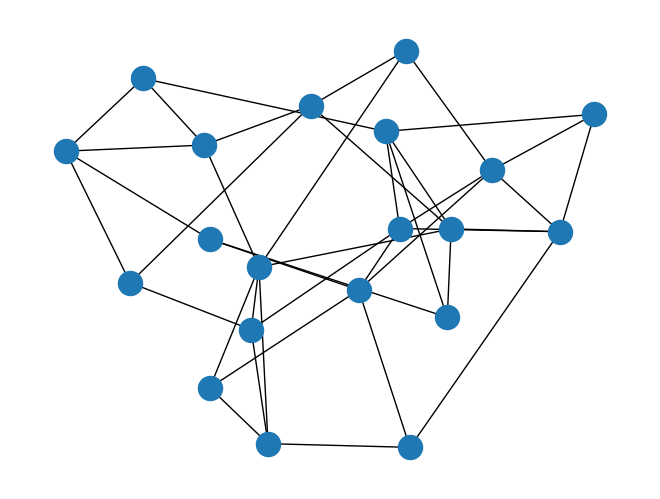

In [20]:
# parametros fijos del modelo
D = create_matrix(G)
path_inicial = path_ejemplo
print(path_inicial, len(path_inicial)) #Obtenemos los datos con los cuales inicializamos la cadena, y volvemos a ver el grafo.
nx.draw(G,)

Calculamos primero una constante $\Delta$ que mayore a la oscilación. Recordando que:

$\Delta > Osc(U) = \max_{x \in E} U(x) - \min_{x \in E} U(x)$

Podemos tomar, por ejemplo, que el máximo de U es $20$ veces la suma de los pesos de todas las aristas (esta cota dependerá del grafo en cuestión, en este caso, uno bien podría recorrer el grafo las veces que se quisiera, pero solo nos limitamos a casos razonables, el 20 acá representa la cantidad de nodos), y el mínimo debe ser a lo menos 1 vez la suma de las aristas (caso euleriano).

Luego, tomamos $\Delta$ como 19 veces esta suma.

In [34]:
total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))

print(f"Suma de pesos: {total_weight}")

Delta = 19*total_weight

Suma de pesos: 209.21920734715647


In [35]:
#funciones beta por comparar
def beta_lin(n,c):
    return n/c
def beta_log(n,c):
    return (1/c)*np.log(1+n)
def beta_cuad(n):
    return n**(2)
def beta_exp(n):
    return 3**n

# beta lineal con c=1
def f1(n, c=1):
    return beta_lin(n,c)
# beta lineal con c fijo como una cota para la oscilación (en este caso, tomamos c=100)
def f2(n, c=Delta):
    return beta_lin(n,c)
# beta logaritmico con c fijo como la cota para la oscilación.
def f3(n, c=Delta):
    return beta_log(n,c)

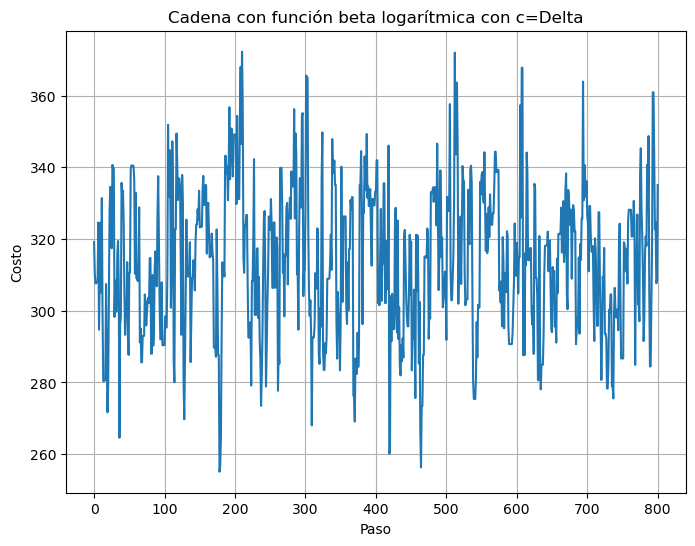

La secuencia de aristas asociada al último camino es: [(0, 1), (3, 17), (15, 17), (1, 8), (4, 6), (6, 8), (2, 4), (15, 16), (0, 18), (16, 18), (8, 17), (6, 7), (10, 12), (11, 13), (17, 18), (0, 2), (9, 10), (11, 19), (1, 3), (8, 10), (17, 19), (2, 3), (10, 14), (7, 8), (5, 7), (2, 5), (7, 12), (4, 13), (12, 18), (14, 16), (12, 13), (3, 5), (13, 14), (11, 12), (13, 15), (10, 11), (1, 19), (7, 9), (9, 11), (16, 17), 0]
El valor obtenido al último camino es de 255.08


In [38]:
#funcion beta logarítmica con constante Delta
I=800
paths, costos = CM(I, f3, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta logarítmica con c=Delta')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt0=min(costos)
opt_path0 = paths[-1]
print("La secuencia de aristas asociada al último camino es:", opt_path0)
print('El valor obtenido al último camino es de {}'.format(round(opt0,2)))

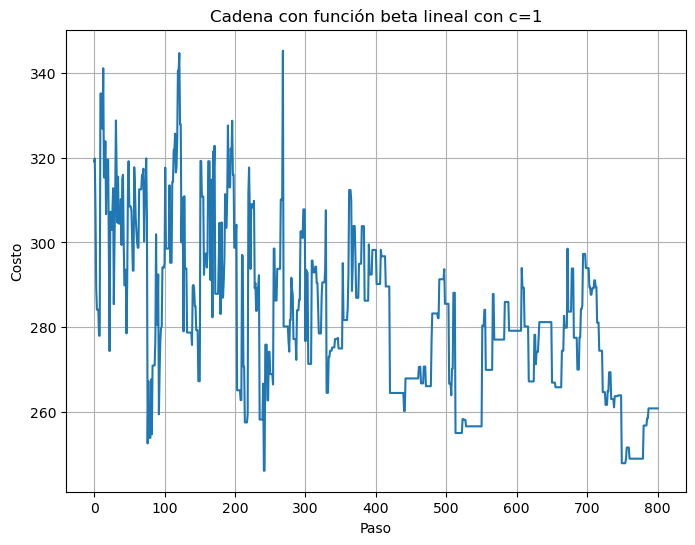

La secuencia de aristas asociada al último camino es: [(0, 2), (10, 12), (10, 11), (15, 17), (7, 9), (15, 16), (0, 18), (1, 19), (1, 3), (8, 10), (17, 18), (13, 14), (2, 5), (11, 19), (2, 3), (0, 1), (10, 14), (3, 5), (9, 11), (9, 10), (14, 16), (12, 18), (17, 19), (5, 7), (7, 8), (7, 12), (11, 13), (2, 4), (8, 17), (11, 12), (1, 8), (6, 8), (6, 7), (16, 17), (4, 13), (3, 17), (12, 13), (16, 18), (4, 6), (13, 15), 0]
El valor obtenido en este último camino es de 246.09


In [39]:
#funcion beta lineal con constante Delta
I=800
paths, costos = CM(I, f2, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta lineal con c=1')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt00=min(costos)
opt_path00 = paths[-1]
print("La secuencia de aristas asociada al último camino es:", opt_path00)
print('El valor obtenido en este último camino es de {}'.format(round(opt00,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


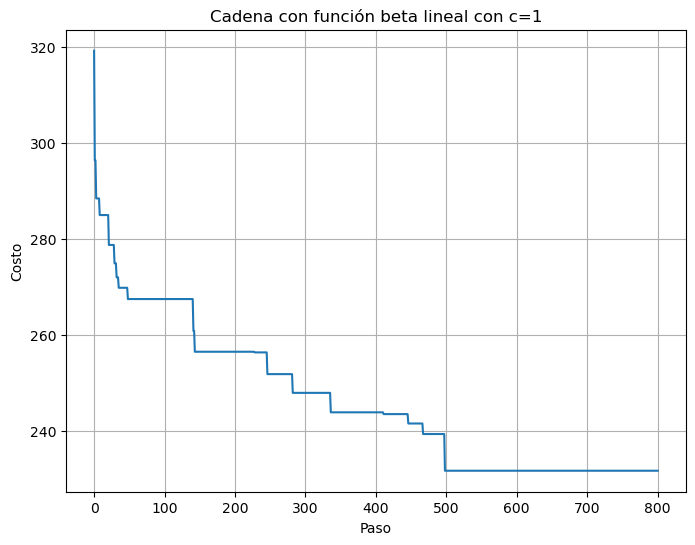

La secuencia de aristas asociada al camino óptimo es: [(0, 18), (11, 19), (12, 13), (8, 10), (17, 19), (16, 18), (17, 18), (9, 11), (15, 16), (13, 14), (10, 14), (15, 17), (0, 2), (3, 17), (1, 19), (12, 18), (1, 3), (2, 5), (2, 4), (0, 1), (6, 8), (7, 8), (16, 17), (10, 11), (7, 9), (13, 15), (4, 13), (4, 6), (6, 7), (11, 12), (2, 3), (10, 12), (8, 17), (14, 16), (1, 8), (9, 10), (11, 13), (7, 12), (5, 7), (3, 5), 0]
El óptimo obtenido es de 231.65


In [29]:
#funcion beta lineal con constante 1
I=800
paths, costos = CM(I, f1, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta lineal con c=1')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt=min(costos)
opt_path = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path)
print('El óptimo obtenido es de {}'.format(round(opt,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


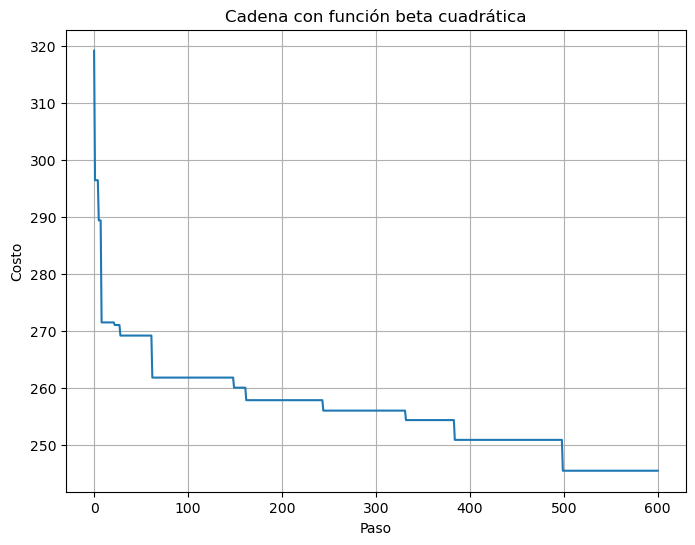

La secuencia de aristas asociada al camino óptimo es: [(0, 1), (11, 19), (16, 18), (17, 18), (15, 17), (2, 4), (2, 5), (3, 5), (0, 2), (10, 12), (1, 8), (1, 3), (2, 3), (10, 11), (13, 14), (1, 19), (8, 10), (9, 11), (16, 17), (10, 14), (7, 9), (15, 16), (13, 15), (9, 10), (7, 12), (11, 12), (4, 6), (6, 7), (0, 18), (6, 8), (8, 17), (5, 7), (12, 18), (3, 17), (14, 16), (17, 19), (12, 13), (4, 13), (11, 13), (7, 8), 0]
El óptimo obtenido es de 245.44


In [31]:
#funcion beta cuadratica
I=600
paths, costos = CM(I, beta_cuad, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta cuadrática')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt2=min(costos)
opt_path2 = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path2)
print('El óptimo obtenido es de {}'.format(round(opt2,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


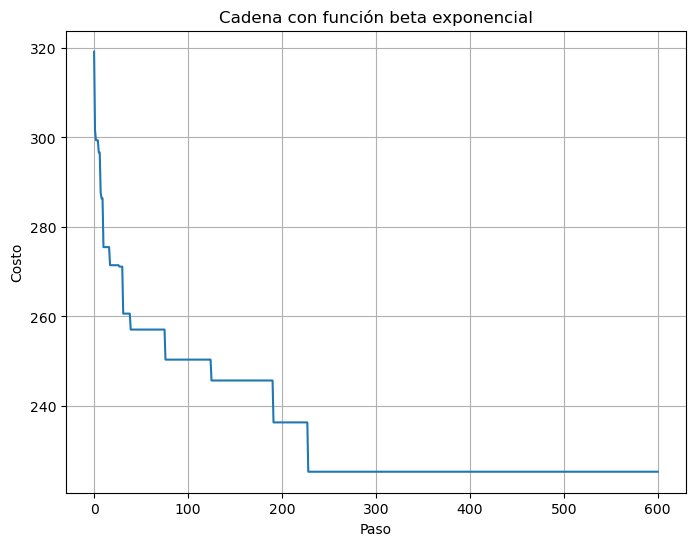

La secuencia de aristas asociada al camino óptimo es: [(0, 2), (2, 5), (10, 14), (7, 12), (15, 16), (11, 12), (1, 3), (3, 5), (1, 8), (10, 11), (17, 19), (13, 15), (17, 18), (13, 14), (3, 17), (5, 7), (9, 10), (2, 4), (2, 3), (8, 10), (10, 12), (7, 9), (6, 7), (0, 18), (7, 8), (0, 1), (9, 11), (16, 17), (15, 17), (11, 13), (12, 13), (12, 18), (6, 8), (14, 16), (11, 19), (4, 13), (1, 19), (4, 6), (8, 17), (16, 18), 0]
El óptimo obtenido es de 225.33


In [30]:
#funcion beta exponencial
I=600
paths, costos = CM(I, beta_exp, path_inicial, G, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta exponencial')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt3=min(costos)
opt_path3 = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path3)
print('El óptimo obtenido es de {}'.format(round(opt3,2)))

In [42]:
opts = [opt,opt00,opt0,opt2,opt3,total_weight]

import pandas as pd
d={'Función Beta': ['Lineal c=1', 'Lineal con c aprox. osc', 'Log. con c aprox. osc', 'Cuadrática', 'Exponencial', 'Suma de pesos'], 
   'Número de Pasos Simulados': [800,800,800,600,600,None],
   'Costo óptimo': opts}
df = pd.DataFrame(data=d)
df

,Función Beta,Número de Pasos Simulados,Costo óptimo
0,Lineal c=1,800.0,231.654893
1,Lineal con c aprox. osc,800.0,246.090810
2,Log. con c aprox. osc,800.0,255.080644
3,Cuadrática,600.0,245.444092
4,Exponencial,600.0,225.328130
5,Suma de pesos,NaN,209.219207


In [43]:
camino = Back2GraphPath(opt_path2,G)
print(camino) #Printeamos el camino reconstruido en G.

[0, 1, 8, 17, 19, 11, 12, 18, 16, 18, 17, 15, 13, 4, 2, 5, 3, 2, 0, 18, 12, 10, 8, 1, 3, 5, 7, 9, 10, 11, 13, 14, 16, 17, 19, 1, 8, 7, 9, 11, 10, 14, 16, 15, 13, 12, 7, 6, 4, 6, 8, 17, 3, 2, 0]


In [2]:
camino = [0, 1, 8, 17, 19, 11, 12, 18, 16, 18, 17, 15, 13, 4, 2, 5, 3, 2, 0, 18, 12, 10, 8, 1, 3, 5, 7, 9, 10, 11, 13, 14, 16, 17, 19, 1, 8, 7, 9, 11, 10, 14, 16, 15, 13, 12, 7, 6, 4, 6, 8, 17, 3, 2, 0]

#### IMPORTANTE:

Recordar que el código que construye la animación del camino en base al grafo, corre a la segunda ejecución, en la primera obliga a matar el kernel pues la ventana pop-up no carga nada. Por esta razón, se redefine el camino arriba.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy
import matplotlib.animation as animation
import matplotlib
import tkinter as tk

matplotlib.use('TkAgg')

num_nodes = 20

p = 0.2  # Rewiring probability
k = 4    # Number of nearest neighbors

H = nx.connected_watts_strogatz_graph(num_nodes, k, p, seed=42)
pos = nx.spring_layout(H, iterations=200)

#Tomamos path como el camino óptimo
path = camino

def draw_next_status(n):
    plt.cla()
    
    #Creamos un nuevo grafo por cada frame
    G = nx.Graph()
    
    #Le añadimos los nodos
    G.add_nodes_from(H.nodes())
    
    #Contamos cuántas veces llegamos a cada nodo (con la cola de la arista)
    node_count = {node: 0 for node in H.nodes()}
    
    #Agregamos aristas de manera progresiva
    for i in range(n + 1):
        edge_start, edge_end = path[i], path[i + 1] if i + 1 < len(path) else path[0]
        
        #Actualizamos el contador de hit de nodos solo con edge_start
        node_count[edge_start] += 1
        
        #Dibujamos aristas en rojo
        G.add_edge(edge_start, edge_end, color='red')
    
    #Coloreamos los nodos dependiendo de cuántas veces han sido alcanzados.
    edge_colors = ['red' for _ in G.edges()]
    node_colors = [f'C{node_count[node]}' for node in G.nodes()]
    
    nx.draw(G, pos, node_color=node_colors, node_size=700, with_labels=True, edge_color=edge_colors, width=2)

ani = animation.FuncAnimation(plt.gcf(), draw_next_status, interval=1000, frames=len(path) - 1, repeat=False)

writer = animation.PillowWriter(fps=1,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('scatter20.gif', writer=writer) #Esta línea guarda la animación como gif, comentarla si no se desea guardar

plt.show()


Ahora, hagamos un ejemplo algo más pesado, con 50 nodos.

In [381]:
import networkx as nx
import random

#Primero, fijamos los nodos en 50
num_nodes = 35

# Nos ayudamos de la función connected_watts_strogatz_graph para construir un grafo conexo simple
p = 0.2  # Rewiring probability
k = 4    # Number of nearest neighbors

G1 = nx.connected_watts_strogatz_graph(num_nodes, k, p, seed=30)


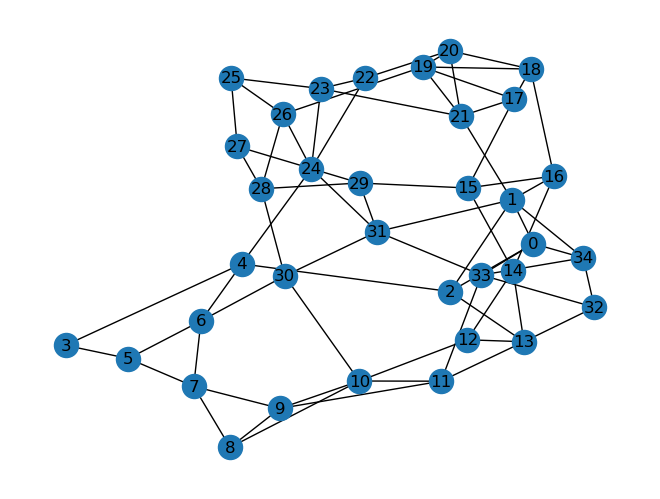

In [382]:
# Asignamos pesos aleatorios entre 1 y 10.
for edge in G1.edges():
    weight = random.uniform(1, 10)
    G1[edge[0]][edge[1]]['weight'] = weight

# Dibujamos el grafo
nx.draw(G1, with_labels=True)

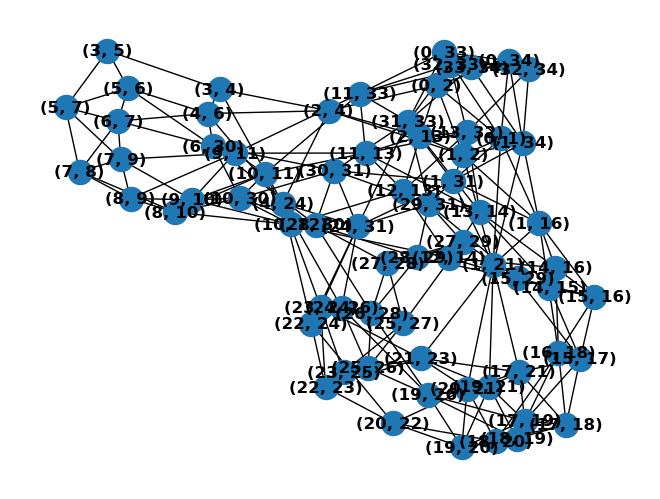

In [383]:
# Generamos el grafo de líneas, que nos servirá para construir la configuración inicial.
L1 = nx.line_graph(G1)

for u, v in L1.edges:
    L1[u][v]['weight'] = 1

for u, v in L1.edges:
    L1[u][v]['shortest_path'] = None
    
# Lo dibujamos
pos = nx.spring_layout(L1)
nx.draw(L1, pos, with_labels=True, font_weight='bold')

plt.show()

In [401]:
l = list(L1.nodes()) #Será una lista de tuplas de aristas.
path_ejemplo = random.sample(l,len(l))
#Le agregamos el 0 al final de la lista, simbolizando que tenemos que volver al nodo inicial tras cumplir con todas las aristas.
path_ejemplo.append(0)

print("El camino inicial es:", path_ejemplo) #Acá tendremos un reordenamiento de los nodos de L, si este reordenamiento es tal que su primera tupla
                    #tiene al 0, avanzamos.

print("\nUn ejemplo de vecino del camino inicial:", vecino(path_ejemplo))

print("\nEjecutar hasta que la primera arista de la secuencia contenga al 0.")


El camino inicial es: [(0, 33), (10, 30), (27, 28), (14, 15), (12, 13), (11, 13), (8, 10), (5, 7), (23, 25), (32, 33), (15, 16), (24, 31), (17, 19), (20, 22), (9, 10), (23, 24), (28, 30), (18, 19), (7, 9), (22, 23), (6, 7), (15, 17), (3, 4), (25, 26), (10, 12), (2, 4), (33, 34), (0, 34), (1, 34), (29, 31), (5, 6), (25, 27), (4, 24), (7, 8), (1, 31), (16, 18), (15, 29), (4, 6), (14, 16), (19, 26), (27, 29), (0, 1), (22, 24), (17, 21), (18, 20), (20, 21), (6, 30), (12, 14), (30, 31), (32, 34), (8, 9), (3, 5), (2, 13), (26, 28), (19, 21), (13, 32), (1, 21), (17, 18), (28, 29), (19, 20), (9, 11), (10, 11), (1, 16), (1, 2), (0, 2), (24, 26), (13, 14), (11, 33), (21, 23), (31, 33), 0]

Un ejemplo de vecino del camino inicial: [(0, 33), (10, 30), (27, 28), (14, 15), (12, 13), (11, 13), (18, 20), (5, 7), (23, 25), (32, 33), (15, 16), (24, 31), (17, 19), (20, 22), (9, 10), (23, 24), (28, 30), (18, 19), (7, 9), (22, 23), (6, 7), (15, 17), (3, 4), (25, 26), (10, 12), (2, 4), (33, 34), (0, 34), (1

[(0, 33), (10, 30), (27, 28), (14, 15), (12, 13), (11, 13), (8, 10), (5, 7), (23, 25), (32, 33), (15, 16), (24, 31), (17, 19), (20, 22), (9, 10), (23, 24), (28, 30), (18, 19), (7, 9), (22, 23), (6, 7), (15, 17), (3, 4), (25, 26), (10, 12), (2, 4), (33, 34), (0, 34), (1, 34), (29, 31), (5, 6), (25, 27), (4, 24), (7, 8), (1, 31), (16, 18), (15, 29), (4, 6), (14, 16), (19, 26), (27, 29), (0, 1), (22, 24), (17, 21), (18, 20), (20, 21), (6, 30), (12, 14), (30, 31), (32, 34), (8, 9), (3, 5), (2, 13), (26, 28), (19, 21), (13, 32), (1, 21), (17, 18), (28, 29), (19, 20), (9, 11), (10, 11), (1, 16), (1, 2), (0, 2), (24, 26), (13, 14), (11, 33), (21, 23), (31, 33), 0] 71


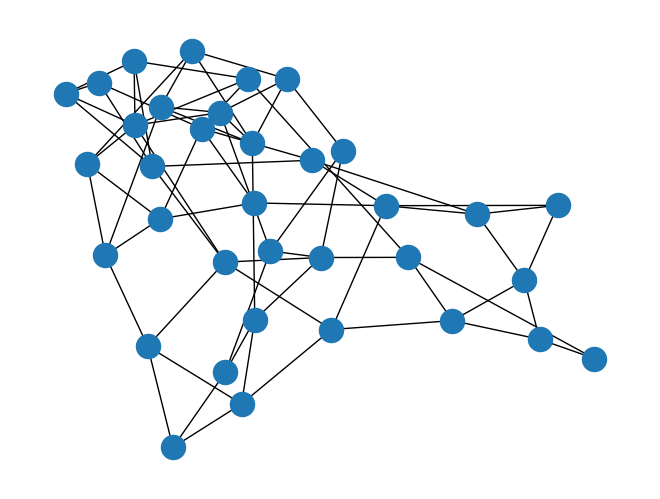

In [402]:
# parametros fijos del modelo
D = create_matrix(G1)
path_inicial = path_ejemplo
print(path_inicial, len(path_inicial)) #Obtenemos los datos con los cuales inicializamos la cadena, y volvemos a ver el grafo.
nx.draw(G1,)

El mismo procedimiento del caso anterior se aplica para encontrar el $\Delta$ que acota las oscilaciones.

In [403]:
total_weight1 = sum(data['weight'] for _, _, data in G1.edges(data=True))

print(f"Suma de pesos: {total_weight1}")

Delta = 34*total_weight1

Suma de pesos: 381.5925513229247


In [405]:
#funciones beta por comparar
def beta_lin(n,c):
    return n/c
def beta_log(n,c):
    return (1/c)*np.log(1+n)
def beta_cuad(n):
    return n**(2)
def beta_exp(n):
    return 3**n

# beta lineal con c=1
def f1(n, c=1):
    return beta_lin(n,c)
# beta lineal con c fijo como una cota para la oscilación
def f2(n, c=Delta):
    return beta_lin(n,c)
# beta logaritmico con c fijo como la cota para la oscilación.
def f3(n, c=Delta):
    return beta_log(n,c)

Corremos la logarítmica con $I = 200$ solo por tema de tiempo de ejecución, puesto que de todas formas esta función no hará que converja.

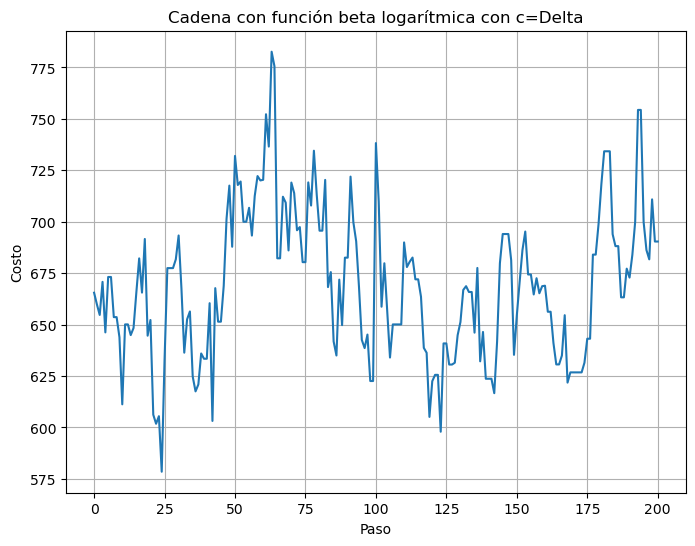

La secuencia de aristas asociada al último camino es: [(0, 2), (31, 33), (12, 13), (20, 22), (18, 20), (19, 21), (13, 14), (22, 23), (27, 29), (22, 24), (33, 34), (28, 29), (19, 26), (0, 34), (2, 4), (29, 31), (32, 34), (1, 16), (30, 31), (0, 33), (23, 25), (21, 23), (2, 13), (12, 14), (7, 9), (10, 11), (10, 30), (32, 33), (1, 31), (20, 21), (4, 24), (1, 34), (5, 7), (1, 2), (24, 31), (24, 26), (6, 30), (7, 8), (18, 19), (28, 30), (25, 26), (6, 7), (1, 21), (8, 9), (8, 10), (4, 6), (16, 18), (19, 20), (17, 18), (15, 17), (13, 32), (14, 15), (27, 28), (14, 16), (11, 33), (10, 12), (25, 27), (26, 28), (5, 6), (11, 13), (3, 4), (0, 1), (15, 16), (17, 19), (9, 11), (9, 10), (23, 24), (15, 29), (17, 21), (3, 5), 0]
El valor obtenido al último camino es de 578.47


In [413]:
#funcion beta logarítmica con constante Delta
I=200
paths, costos = CM(I, f3, path_inicial, G1, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta logarítmica con c=Delta')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt0=min(costos)
opt_path0 = paths[-1]
print("La secuencia de aristas asociada al último camino es:", opt_path0)
print('El valor obtenido al último camino es de {}'.format(round(opt0,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


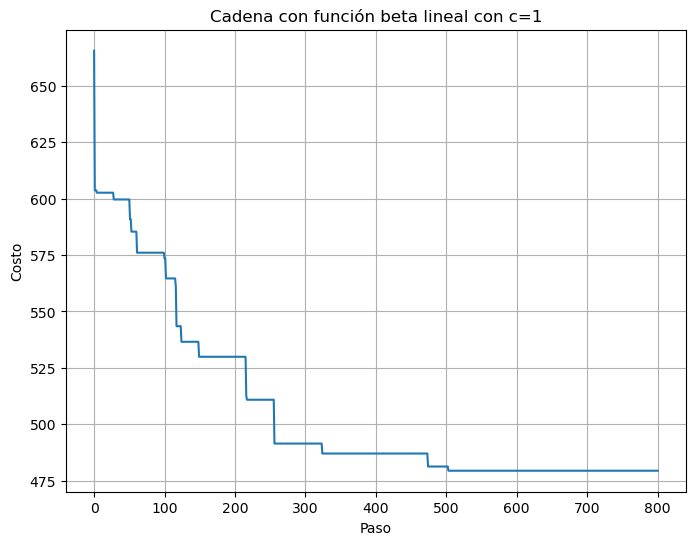

La secuencia de aristas asociada al camino óptimo es: [(0, 33), (16, 18), (25, 27), (15, 16), (1, 34), (32, 33), (11, 13), (5, 7), (3, 5), (32, 34), (17, 19), (24, 31), (17, 18), (20, 22), (11, 33), (27, 28), (7, 9), (1, 16), (23, 24), (1, 21), (19, 21), (23, 25), (22, 24), (25, 26), (10, 12), (8, 9), (0, 1), (21, 23), (7, 8), (15, 17), (17, 21), (0, 2), (22, 23), (28, 29), (4, 6), (26, 28), (5, 6), (27, 29), (18, 19), (13, 14), (19, 20), (19, 26), (6, 7), (1, 31), (33, 34), (9, 11), (12, 13), (12, 14), (29, 31), (4, 24), (8, 10), (28, 30), (14, 16), (14, 15), (20, 21), (30, 31), (2, 13), (13, 32), (10, 11), (3, 4), (10, 30), (2, 4), (6, 30), (1, 2), (15, 29), (24, 26), (31, 33), (18, 20), (0, 34), (9, 10), 0]
El óptimo obtenido es de 479.44


In [411]:
#funcion beta lineal con constante 1
I=800
paths, costos = CM(I, f1, path_inicial, G1, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta lineal con c=1')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt=min(costos)
opt_path = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path)
print('El óptimo obtenido es de {}'.format(round(opt,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


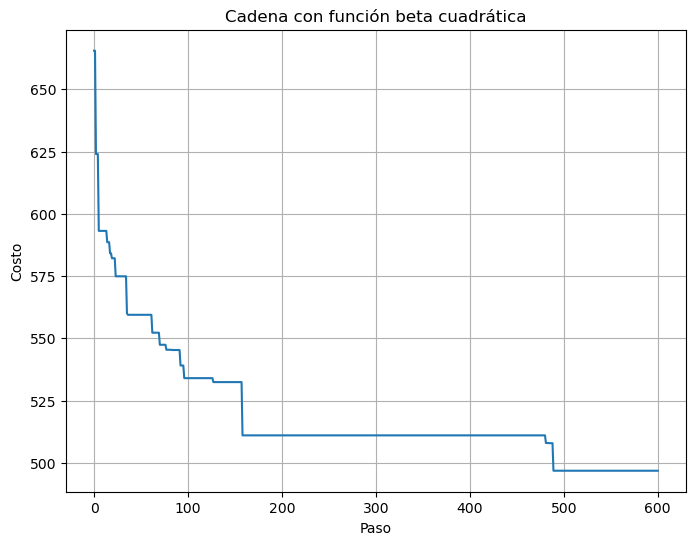

La secuencia de aristas asociada al camino óptimo es: [(0, 34), (10, 30), (27, 28), (14, 15), (12, 13), (2, 13), (27, 29), (23, 25), (11, 33), (25, 26), (24, 26), (15, 17), (4, 24), (13, 14), (12, 14), (26, 28), (13, 32), (18, 19), (7, 9), (3, 4), (1, 2), (15, 16), (17, 21), (28, 30), (22, 23), (24, 31), (22, 24), (0, 33), (8, 10), (29, 31), (10, 12), (33, 34), (1, 16), (5, 6), (3, 5), (21, 23), (0, 1), (28, 29), (25, 27), (23, 24), (19, 20), (5, 7), (31, 33), (10, 11), (32, 33), (17, 19), (14, 16), (32, 34), (30, 31), (8, 9), (16, 18), (9, 10), (20, 21), (2, 4), (1, 31), (11, 13), (6, 30), (19, 26), (15, 29), (0, 2), (9, 11), (1, 34), (6, 7), (1, 21), (4, 6), (17, 18), (19, 21), (18, 20), (20, 22), (7, 8), 0]
El óptimo obtenido es de 496.87


In [407]:
#funcion beta cuadratica
I=600
paths, costos = CM(I, beta_cuad, path_inicial, G1, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta cuadrática')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt2=min(costos)
opt_path2 = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path2)
print('El óptimo obtenido es de {}'.format(round(opt2,2)))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15896\1953681732.py:19: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta * (new_cost - fn_costos(D,path,G))))


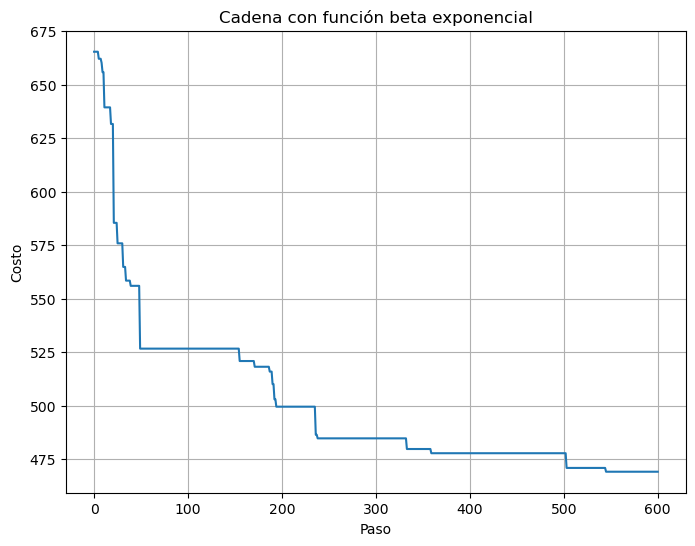

La secuencia de aristas asociada al camino óptimo es: [(0, 33), (10, 30), (17, 21), (14, 15), (1, 31), (11, 13), (7, 9), (5, 7), (23, 25), (32, 33), (5, 6), (29, 31), (17, 19), (20, 22), (6, 7), (8, 10), (9, 10), (18, 19), (17, 18), (22, 23), (27, 29), (25, 26), (26, 28), (6, 30), (7, 8), (0, 34), (33, 34), (11, 33), (2, 13), (20, 21), (3, 5), (24, 26), (14, 16), (1, 2), (9, 11), (19, 20), (15, 29), (4, 24), (1, 21), (27, 28), (19, 21), (25, 27), (4, 6), (15, 17), (21, 23), (18, 20), (10, 11), (12, 14), (28, 30), (32, 34), (1, 34), (23, 24), (31, 33), (30, 31), (8, 9), (15, 16), (2, 4), (12, 13), (19, 26), (24, 31), (13, 14), (0, 2), (16, 18), (10, 12), (1, 16), (0, 1), (13, 32), (3, 4), (28, 29), (22, 24), 0]
El óptimo obtenido es de 469.11


In [409]:
#funcion beta exponencial
I=600
paths, costos = CM(I, beta_exp, path_inicial, G1, D)
plt.figure(figsize=(8, 6))
plt.plot(costos)
plt.grid()
plt.title('Cadena con función beta exponencial')
plt.ylabel('Costo')
plt.xlabel('Paso')
plt.show()

opt3=min(costos)
opt_path3 = paths[-1]
print("La secuencia de aristas asociada al camino óptimo es:", opt_path3)
print('El óptimo obtenido es de {}'.format(round(opt3,2)))

In [415]:
opts1 = [opt,opt00,opt0,opt2,opt3,total_weight1]

import pandas as pd
d={'Función Beta': ['Lineal c=1', 'Lineal con c aprox. osc', 'Log. con c aprox. osc', 'Cuadrática', 'Exponencial', 'Suma de pesos'], 
   'Número de Pasos Simulados': [200,800,800,600,600,None],
   'Costo óptimo': opts1}
df = pd.DataFrame(data=d)
df

,Función Beta,Número de Pasos Simulados,Costo óptimo
0,Lineal c=1,200.0,479.438595
1,Lineal con c aprox. osc,800.0,246.090810
2,Log. con c aprox. osc,800.0,578.472548
3,Cuadrática,600.0,496.869244
4,Exponencial,600.0,469.109268
5,Suma de pesos,NaN,381.592551


In [417]:
camino = Back2GraphPath(opt_path2,G1)
print(camino) #Printeamos el camino reconstruido en G.

[0, 34, 33, 11, 9, 8, 10, 30, 28, 27, 29, 15, 14, 13, 12, 13, 2, 4, 24, 23, 25, 26, 24, 26, 19, 17, 15, 14, 12, 10, 30, 28, 26, 19, 18, 16, 14, 13, 32, 33, 11, 9, 7, 6, 4, 3, 4, 2, 1, 16, 15, 17, 21, 23, 22, 24, 31, 33, 0, 2, 1, 31, 29, 28, 30, 6, 5, 3, 4, 2, 1, 0, 2, 1, 31, 29, 27, 25, 23, 21, 19, 20, 21, 1, 2, 4, 3, 5, 7, 8, 10, 11, 33, 32, 34, 1, 31, 30, 10, 9, 11, 13, 14, 16, 18, 17, 18, 20, 22, 24, 4, 2, 0]


In [4]:
camino = [0, 34, 33, 11, 9, 8, 10, 30, 28, 27, 29, 15, 14, 13, 12, 13, 2, 4, 24, 23, 25, 26, 24, 26, 19, 17, 15, 14, 12, 10, 30, 28, 26, 19, 18, 16, 14, 13, 32, 33, 11, 9, 7, 6, 4, 3, 4, 2, 1, 16, 15, 17, 21, 23, 22, 24, 31, 33, 0, 2, 1, 31, 29, 28, 30, 6, 5, 3, 4, 2, 1, 0, 2, 1, 31, 29, 27, 25, 23, 21, 19, 20, 21, 1, 2, 4, 3, 5, 7, 8, 10, 11, 33, 32, 34, 1, 31, 30, 10, 9, 11, 13, 14, 16, 18, 17, 18, 20, 22, 24, 4, 2, 0]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy
import matplotlib.animation as animation
import matplotlib
import tkinter as tk

matplotlib.use('TkAgg')

#Primero, fijamos los nodos en 35
num_nodes = 35

# Nos ayudamos de la función connected_watts_strogatz_graph para construir un grafo conexo simple
p = 0.2  # Rewiring probability
k = 4    # Number of nearest neighbors

H = nx.connected_watts_strogatz_graph(num_nodes, k, p, seed=30)
pos = nx.spring_layout(H, iterations=200)

#Tomamos path como el camino óptimo
path = camino

def draw_next_status(n):
    plt.cla()
    
    #Creamos un nuevo grafo por cada frame
    G = nx.Graph()
    
    #Le añadimos los nodos
    G.add_nodes_from(H.nodes())
    
    #Contamos cuántas veces llegamos a cada nodo (con la cola de la arista)
    node_count = {node: 0 for node in H.nodes()}
    
    #Agregamos aristas de manera progresiva
    for i in range(n + 1):
        edge_start, edge_end = path[i], path[i + 1] if i + 1 < len(path) else path[0]
        
        #Actualizamos el contador de hit de nodos solo con edge_start
        node_count[edge_start] += 1
        
        #Dibujamos aristas en rojo
        G.add_edge(edge_start, edge_end, color='red')
    
    #Coloreamos los nodos dependiendo de cuántas veces han sido alcanzados.
    edge_colors = ['red' for _ in G.edges()]
    node_colors = [f'C{node_count[node]}' for node in G.nodes()]
    
    nx.draw(G, pos, node_color=node_colors, node_size=700, with_labels=True, edge_color=edge_colors, width=2)

ani = animation.FuncAnimation(plt.gcf(), draw_next_status, interval=1000, frames=len(path) - 1, repeat=False)

writer = animation.PillowWriter(fps=1,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('scatter35.gif', writer=writer) #Esta línea guarda la animación como gif, comentarla si no se desea guardar

plt.show()
